In [1]:
import urllib.request as req
from bs4 import BeautifulSoup
import requests

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException

import re
import time
import json
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from nltk.tokenize import word_tokenize, WordPunctTokenizer
from konlpy.tag import Okt, Mecab, Kkma

from wordcloud import WordCloud
from collections import Counter
from PIL import Image
from eunjeon import Mecab

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [66]:
import warnings

warnings.simplefilter("ignore")

## 1. 크롤링

In [3]:
# 크롤링 함수 

def NaverBlog(scroll_num, query, date_from, date_to):
    

    url = 'https://search.naver.com/search.naver'
    hrd = {'User-Agent':'Mozilla/5.0', 'referer':'http://naver.com'}
    param = {
        'where' : 'blog',
        'query' : query,
        'date_from' : date_from,
        'date_to' : date_to,
        'date_option' : '8'
    }
    
    response = requests.get(url, params=param, headers=hrd)

    driver = webdriver.Chrome('chromedriver.exe')
    driver.get(response.url)
    time.sleep(2)
    
    for i in range(scroll_num) :
        driver.find_element(By.CSS_SELECTOR, 'body').send_keys(Keys.PAGE_DOWN)
        time.sleep(1)
    

    html = driver.page_source
    soup = BeautifulSoup(html,'html.parser')
    area = soup.find_all("a", {"class":"api_txt_lines total_tit"})

    url_list=[]
    for tag in area:
        try:
            url=tag.get('href')
            html_result = requests.get(url)
            soup_temp = BeautifulSoup(html_result.text, 'html.parser')
            area_temp = soup_temp.find(id='mainFrame')
            url_list.append("https://blog.naver.com" + area_temp.get('src'))
           
        except :
            pass

        
    body_list=[]
    date_list=[]
    id_list = []
    
    for url in url_list :
        
        res = req.urlopen(url)
        soup = BeautifulSoup(res, 'html.parser')
        driver.get(url=url)
  
        try:
            
            if soup.find("div", {"class":"se-main-container"}):

                id = url.split('/')[3].split('&')[0].split('=')[1]
                id_list.append(id)

                date = soup.find("span", {"class":"se_publishDate pcol2"}).get_text()
                date_list.append(date)

                body = soup.find("div", {"class":"se-main-container"}).get_text()
                body = body.strip().replace('\n',' ').replace('\t',' ').replace('\r',' ').replace(u'\xa0',u' ').replace(u'\u200b', u' ')
                body_list.append(body)        


            else :

                id = url.split('/')[3].split('&')[0].split('=')[1]
                id_list.append(id)

                date = soup.find("p", {"class":"date fil5 pcol2 _postAddDate"}).get_text()
                date_list.append(date)

                body = soup.find("div", {"id":"postViewArea"}).get_text()
                body = body.strip().replace('\n',' ').replace('\t',' ').replace('\r',' ').replace(u'\xa0',u' ').replace(u'\u200b', u' ')
                body_list.append(body)

        except:
            pass    
        

    driver.quit()
    
    df = pd.DataFrame({'ID' : pd.Series(id_list), 'Date' : pd.Series(date_list), 'Text':pd.Series(body_list)}, index=list(range(len(id_list))))

    return df

In [3]:
scr = 200
key = '"금리"'

df0 = NaverBlog(scr, key, '20220526', '20220712') # 기준금리 변동 시점 기준
df1 = NaverBlog(scr, key, '20220825', '20221011')

C:\Users\1dk1d\AppData\Local\Temp\ipykernel_15744\999354851.py:18: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('chromedriver.exe')
C:\Users\1dk1d\AppData\Local\Temp\ipykernel_15744\999354851.py:18: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('chromedriver.exe')


In [4]:
df0.to_csv('interest_df1.csv')
df1.to_csv('interest_df2.csv')

In [67]:
df0 = pd.read_csv('interest_df1.csv').drop(['Unnamed: 0'], axis = 1)
df1 = pd.read_csv('interest_df2.csv').drop(['Unnamed: 0'], axis = 1)

In [68]:
print('데이터 프레임1 크기 :', df0.shape, '\n데이터 프레임2 크기 :', df1.shape)
display(df0.head())
display(df1.head())

데이터 프레임1 크기 : (673, 3) 
데이터 프레임2 크기 : (631, 3)


,ID,Date,Text
0,rboder,2022. 7. 1. 5:07,미국 중앙은행인 연방준비제도가 치솟는 소비자 물가를 잡기 위해 기준금리 0.75%p...
1,lovezib,2022. 7. 6. 10:00,누구나 가지고 있는목표는 다를 테지만저는 일 년이란 시간 안에자차를 뽑는 게 목표였...
2,ihyeon_isme,2022. 6. 5. 23:02,물론 은행의 지분 없이 불가한 일이지만그래도 빚도 내 재산이라고 하였느니..발...
3,dongjiwari,2022. 7. 5. 17:00,"생애최초 주택자금대출 금리 & 조건 알아보기, 취득세 감면 요즘 주유소 가기 정말 ..."
4,resumet,2022. 6. 20. 21:22,보금자리론 대출자격 금리 무섭던 주택 가격 상승...


,ID,Date,Text
0,lemon6088,2022. 10. 11. 12:45,주택시장의 각종 규제가 풀리면서 부동산 시...
1,muksodang,2022. 8. 26. 10:22,한국은행 기준...
2,cristal59,2022. 9. 26. 8:00,"예전에는 주로 주식을 하는 분들만 알던 파킹통장이었는데,2021년 10월경 토스가 ..."
3,topjoys,2022. 10. 3. 23:10,1금융권에서 신용 990점이 넘는다고 하더라도 이제 기본 금리 6%를 피할 수 없습...
4,morgoth,2022. 9. 22. 10:49,"인플레이션을 막아낸다는 명분으로, 미 연준의 기준금리 인상이 이어지고 있습니다. 9..."


## 2. 전처리, 토큰화, DTM 함수

In [69]:
# 데이터 전처리

stopwords = pd.read_csv("stopwords.txt").values.tolist()
stopwords = sum(stopwords, [])

def preprocessing(df) :
    
    df = df.dropna(axis = 0).reset_index(drop = True)
    
    pre_txt = []
    for t in df['Text'] :
        txt = re.compile('[^가-힣\s]').sub('', t)
        pre_txt.append(txt)      
    
    df['pre_text'] = pre_txt
    
    return df


def token(df) :

    text = list(df['pre_text'])
    mecab = Mecab()

    token = list(map(lambda x : mecab.nouns(x), text))
#     token = list(map(lambda x : " ".join(x), token))
    
    return token


def Bow(token) :
    
    token = list(map(lambda x : " ".join(x), token))
    vector = CountVectorizer(stop_words = stopwords)
    
    bow = vector.fit_transform(token)
    
    columns = []
    for k, v in sorted(vector.vocabulary_.items(), key = lambda item:item[1]) :
        columns.append(k)
        
    dtm = pd.DataFrame(bow.toarray(), columns = columns)
    
    return dtm

In [70]:
print('[DataFrame1]\n', df0.isnull().sum())
interest_1 = preprocessing(df0)
print('------------------->\n', interest_1.isnull().sum())
print('\n===============================')

print('[DataFrame2]\n', df1.isnull().sum())
interest_2 = preprocessing(df1)
print('------------------->\n', interest_2.isnull().sum())

[DataFrame1]
 ID      0
Date    2
Text    2
dtype: int64
------------------->
 ID          0
Date        0
Text        0
pre_text    0
dtype: int64

[DataFrame2]
 ID      0
Date    4
Text    4
dtype: int64
------------------->
 ID          0
Date        0
Text        0
pre_text    0
dtype: int64


In [71]:
token_1 = token(interest_1)
token_2 = token(interest_2)

In [72]:
dtm_1 = Bow(token_1)
dtm_2 = Bow(token_2)
print('[dtm_1]', dtm_1.shape)
display(dtm_1.head())
print('[dtm_2]', dtm_2.shape)
display(dtm_2.head())

[dtm_1] (671, 9060)


,가게,가격,가격대,가격표,가계,가계부,가공,가구,가구주,가금,...,희소성,희소식,희토류,흰색,히스,히스토리,히토,힌트,힐러리,힐링
0,0,4,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


[dtm_2] (627, 7165)


,가감,가게,가격,가격대,가계,가계부,가공,가교,가구,가까이,...,흥국,흥미,흥원,희망,희생,희소,희소식,희열,흰색,힐튼
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


## 3. 워드클라우드

In [81]:
def cloud(img_file, fre) :

    img = Image.open(img_file)
    img_array = np.array(img)

    wc = WordCloud(font_path = 'malgun', background_color="white", colormap = 'PuBu', 
                   width = 500, height = 500, max_font_size = 250, mask = img_array)
    gen = wc.generate_from_frequencies(fre)

    return gen

(-0.5, 511.5, 511.5, -0.5)

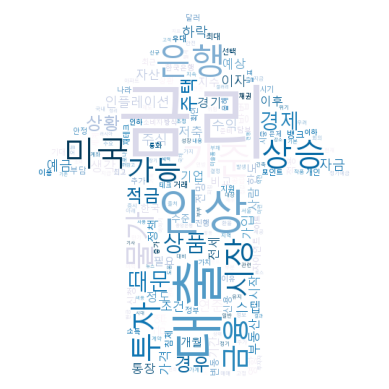

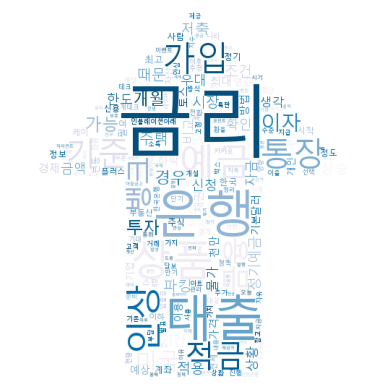

In [82]:
fre_1 = dtm_1.sum(axis = 0).to_dict()
fre_2 = dtm_2.sum(axis = 0).to_dict()

gen_1 = cloud('arrow2.png', fre_1)
gen_2 = cloud('arrow2.png', fre_2)

fig = plt.figure()
plt.imshow(gen_1)
plt.axis('off')     

fig = plt.figure()
plt.imshow(gen_2)
plt.axis('off')   

## 4. LDA 모델 - 최적 토픽수 결정

In [20]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [34]:
# topic 수 결정(token_1)

dic_1 = corpora.Dictionary(token_1)
dic_1.filter_extremes(no_below = 2, no_above = 0.5)
corpus_1 = [dic_1.doc2bow(token) for token in token_1]

coherence_score = []

for i in range(2, 10) :
    
    model = LdaModel(corpus = corpus_1, id2word = dic_1, num_topics = i, passes = 5)
    coherence_model = CoherenceModel(model, texts = token_1, dictionary = dic_1, coherence = 'c_v')
    coherence_lda = coherence_model.get_coherence()
    
    print('k =', i, '\nCoherence Score :', coherence_lda)
    
    coherence_score.append(coherence_lda)

k = 2 
Coherence Score : 0.47529507078539
k = 3 
Coherence Score : 0.5569203596854228
k = 4 
Coherence Score : 0.4136844325980335
k = 5 
Coherence Score : 0.6216235805194541
k = 6 
Coherence Score : 0.5149375665472663
k = 7 
Coherence Score : 0.5596754292195815
k = 8 
Coherence Score : 0.5620288356623651
k = 9 
Coherence Score : 0.47640529496906747


In [36]:
# topic 수 결정(token_2)

dic_2 = corpora.Dictionary(token_2)
dic_2.filter_extremes(no_below = 2, no_above = 0.5)
corpus_2 = [dic_2.doc2bow(token) for token in token_2]

coherence_score = []

for i in range(2, 10) :
    
    model = LdaModel(corpus = corpus_2, id2word = dic_2, num_topics = i, passes = 5)
    coherence_model = CoherenceModel(model, texts = token_2, dictionary = dic_2, coherence = 'c_v')
    coherence_lda = coherence_model.get_coherence()
    
    print('k =', i, '\nCoherence Score :', coherence_lda)
    
    coherence_score.append(coherence_lda)

k = 2 
Coherence Score : 0.45080089666551604
k = 3 
Coherence Score : 0.44400837150129163
k = 4 
Coherence Score : 0.5992800250464774
k = 5 
Coherence Score : 0.6242327757134742
k = 6 
Coherence Score : 0.552529571484098
k = 7 
Coherence Score : 0.5805760865354853
k = 8 
Coherence Score : 0.575854252756107
k = 9 
Coherence Score : 0.5970383991826442


## 5. LDA 모델 적용

In [83]:
dic_1 = corpora.Dictionary(token_1)
dic_1.filter_extremes(no_below = 2, no_above = 0.5)
corpus_1 = [dic_1.doc2bow(token) for token in token_1]

dic_2 = corpora.Dictionary(token_2)
dic_2.filter_extremes(no_below = 2, no_above = 0.5)
corpus_2 = [dic_2.doc2bow(token) for token in token_2]


def modeling(token, dic, corpus) :
    
    dic = corpora.Dictionary(token)
    dic.filter_extremes(no_below = 2, no_above = 0.5)
    corpus = [dic.doc2bow(t) for t in token]
    
    model = LdaModel(corpus = corpus, id2word = dic, num_topics = 4, passes = 5)
    
    prepare_data = gensimvis.prepare(model, corpus, dic)
    
    return model, prepare_data

In [93]:
model_1, img_data_1 = modeling(token_1, dic_1, corpus_1)
model_2, img_data_2 = modeling(token_2, dic_2, corpus_2)

print('\n')
display()model_1.print_topics()
print('\n')
display(model_2.print_topics())

[(0,
  '0.019*"미국" + 0.013*"물가" + 0.011*"경제" + 0.010*"투자" + 0.009*"하락" + 0.008*"인플레이션" + 0.008*"가격" + 0.008*"경기" + 0.007*"주식" + 0.006*"연준"'),
 (1,
  '0.040*"대출" + 0.016*"주택" + 0.008*"전세" + 0.008*"스텝" + 0.007*"경우" + 0.007*"미국" + 0.007*"자금" + 0.007*"억" + 0.006*"물가" + 0.005*"연준"'),
 (2,
  '0.027*"대출" + 0.016*"투자" + 0.014*"상품" + 0.011*"수익" + 0.010*"적금" + 0.010*"분" + 0.008*"예금" + 0.008*"아트" + 0.008*"경우" + 0.007*"방법"'),
 (3,
  '0.022*"가입" + 0.021*"통장" + 0.020*"적금" + 0.016*"예금" + 0.015*"저축" + 0.013*"뱅크" + 0.012*"상품" + 0.011*"우대" + 0.010*"파킹" + 0.010*"연"')]

[(0,
  '0.029*"가입" + 0.028*"적금" + 0.025*"예금" + 0.019*"개월" + 0.015*"뱅크" + 0.012*"통장" + 0.012*"우대" + 0.012*"정기예금" + 0.011*"우리" + 0.009*"적용"'),
 (1,
  '0.048*"대출" + 0.015*"주택" + 0.012*"통장" + 0.012*"신청" + 0.011*"억" + 0.010*"경우" + 0.009*"예금" + 0.009*"한도" + 0.009*"저축" + 0.009*"조건"'),
 (2,
  '0.024*"미국" + 0.012*"시장" + 0.012*"상승" + 0.011*"물가" + 0.010*"달러" + 0.009*"하락" + 0.008*"연준" + 0.008*"경제" + 0.007*"투자" + 0.007*"상황"'),
 (3,
  '0.024*"투자" + 0.020*"통장" + 0.015*"뱅크" + 0.015*"수익" + 0.014*"예금" + 0.011*"파킹" + 0.011*"아트" + 0.011*"분" + 0.010*"토스" + 0.009*"가입"')]

## 6. 시각화

In [91]:
pyLDAvis.display(img_data_1)

In [92]:
pyLDAvis.display(img_data_2)